## Los datos
- Grupo
- Sexo
- Edad
- Modo_Llegada
- Lesión
- Queja_Principal
- Estado_Mental
- Dolor
- Dolor_NRS
- SBP
- DBP
- HR
- RR
- BT
- Saturación
- KTAS_Enfermera
- Diagnóstico_Urgencias
- Disposición
- KTAS_Experto
- Grupo_Error
- Duración_Estancia_Min
- Duración_KTAS_Min
- Error_Triaje


In [637]:
import numpy as np
import pandas as pd

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import scipy.stats as stats
import scipy.optimize as optimize

## 1. Carga de los datos

In [581]:
datos = pd.read_csv("./data/Regresión_train_data.csv")

In [582]:
datos.shape

(1000, 23)

In [583]:
datos.dtypes

Grupo                         int64
Sexo                          int64
Edad                          int64
Modo_Llegada                  int64
Lesion                        int64
Queja_Principal              object
Estado_Mental                 int64
Dolor                         int64
dolor_NRS                    object
SBP                         float64
DBP                         float64
HR                          float64
RR                          float64
BT                          float64
Saturacion                  float64
KTAS_enfermera                int64
Diagnostico_En_Urgencias     object
Disposicion                   int64
KTAS_experto                  int64
Grupo_De_Error                int64
Duracion_Estancia_Min         int64
Duracion_KTAS_Min            object
Error_Triaje                  int64
dtype: object

In [584]:
datos.sample(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,BT,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje
610,1,1,39,3,1,abd pain,1,1,3,114.0,...,37.4,NaN,4,Epigastric pain,1,4,0,183,"4,15",0
478,2,2,49,3,1,syncope,1,1,8,140.0,...,36.0,99.0,2,Myocardial infarction with non-ST elevation,2,2,0,10286,"3,00",0
759,2,2,58,2,1,"Fever, Unspecified",1,0,#BOÞ!,140.0,...,37.8,99.0,4,"Viral infection, unspecified",1,4,0,742,"2,00",0
669,1,2,83,2,1,distended abdomen,1,0,#BOÞ!,124.0,...,36.0,NaN,3,Small cell lung cancer unspecified side,1,3,0,504,"5,97",0
782,1,2,49,3,2,finger laceration,1,0,#BOÞ!,142.0,...,36.5,NaN,4,Laceration of finger without nail damage,1,4,0,48,"6,95",0


## 2. Entendimiento de los datos

Variables numericas candidatas a utilizar

In [640]:
candidatas = ["Edad","Disposicion","KTAS_experto","Duracion_KTAS_Min","EWS"]
numericas=["Grupo", "Sexo", "Edad", "Modo_Llegada", "Lesion", "Estado_Mental", "Dolor", "dolor_NRS", "KTAS_enfermera", "Disposicion", "KTAS_experto", "Duracion_Estancia_Min", "Duracion_KTAS_Min"]

In [586]:
datos.describe()

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Estado_Mental,Dolor,SBP,DBP,HR,RR,BT,Saturacion,KTAS_enfermera,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Error_Triaje
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.0000,1000.000000,1000.000000,983.000000,979.000000,988.000000,985.000000,989.000000,444.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,1.450000,1.514000,53.892000,2.811000,1.2000,1.103000,0.562000,133.485249,79.566905,84.400810,19.450761,36.562993,97.047297,3.328000,1.610000,3.260000,0.569000,12792.480000,0.253000
std,0.497743,0.500054,19.826483,0.796186,0.4002,0.431946,0.496389,27.156136,15.174593,16.297428,2.069882,0.519699,4.761112,0.862067,1.161572,0.865534,1.587375,87721.151446,0.630387
min,1.000000,1.000000,16.000000,1.000000,1.0000,1.000000,0.000000,50.000000,31.000000,32.000000,14.000000,35.000000,20.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,36.000000,2.000000,1.0000,1.000000,0.000000,114.000000,70.000000,73.000000,18.000000,36.200000,97.000000,3.000000,1.000000,3.000000,0.000000,132.750000,0.000000
50%,1.000000,2.000000,56.000000,3.000000,1.0000,1.000000,1.000000,130.000000,80.000000,82.000000,20.000000,36.500000,98.000000,3.000000,1.000000,3.000000,0.000000,270.500000,0.000000
75%,2.000000,2.000000,70.250000,3.000000,1.0000,1.000000,1.000000,150.000000,90.000000,96.000000,20.000000,36.800000,99.000000,4.000000,2.000000,4.000000,0.000000,620.000000,0.000000
max,2.000000,2.000000,94.000000,7.000000,2.0000,4.000000,1.000000,275.000000,160.000000,148.000000,30.000000,39.800000,100.000000,5.000000,7.000000,5.000000,9.000000,709510.000000,2.000000


In [587]:
datos["Sexo"].value_counts()


Sexo
2    514
1    486
Name: count, dtype: int64

In [588]:
datos["dolor_NRS"].value_counts()

dolor_NRS
#BOÞ!    440
3        209
4        111
5        109
6         59
2         31
7         27
8          8
10         3
1          2
9          1
Name: count, dtype: int64

In [589]:
datos["Error_Triaje"].value_counts()

Error_Triaje
0    851
2    104
1     45
Name: count, dtype: int64

In [590]:
datos["Modo_Llegada"].value_counts()

Modo_Llegada
3    588
2    220
4    122
1     60
6      7
5      2
7      1
Name: count, dtype: int64

In [591]:
datos["Grupo_De_Error"].value_counts().sort_index()


Grupo_De_Error
0    851
1     16
2     39
3      6
4     50
5     11
6      6
7      7
8      9
9      5
Name: count, dtype: int64

In [592]:
datos["Queja_Principal"].value_counts().sort_index()

Queja_Principal
??                       5
?? ??                    1
?? ???                   2
?? ??? ??                1
???                      3
                        ..
weakness                 1
whirling type vertigo    3
wrist laceration         1
wrist pain, Lt           1
wrist pain, Rt           1
Name: count, Length: 347, dtype: int64

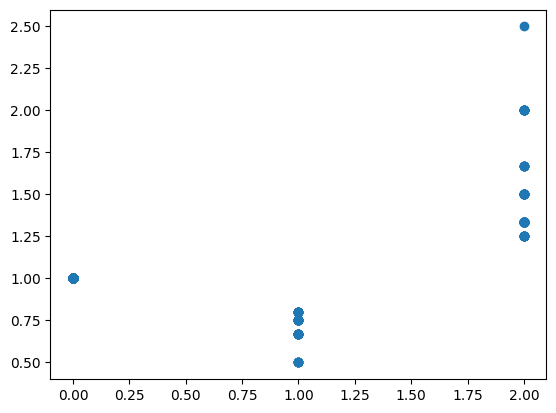

In [593]:
datos[["KTAS_enfermera","KTAS_experto","Error_Triaje"]]
a = datos[datos["KTAS_enfermera"]!=datos["KTAS_experto"]][["KTAS_enfermera","KTAS_experto","Error_Triaje"]]
a[a["Error_Triaje"]==1]
plt.scatter(datos["Error_Triaje"], datos["KTAS_enfermera"]/datos["KTAS_experto"])


In [594]:
def calcularEWS(registro):
    total = 0
    
    # Frecuencia respiratoria (RR)
    if registro['RR'] <= 8:
        total += 2
    elif 9 <= registro['RR'] <= 14:
        total += 0
    elif 15 <= registro['RR'] <= 20:
        total += 1
    elif 21 <= registro['RR'] <= 29:
        total += 2
    elif registro['RR'] >= 30:
        total += 3
    
    # Presión arterial sistólica (SBP)
    if registro['SBP'] <= 70:
        total += 3
    elif 71 <= registro['SBP'] <= 80:
        total += 2
    elif 81 <= registro['SBP'] <= 100:
        total += 1
    elif 101 <= registro['SBP'] <= 199:
        total += 0
    elif registro['SBP'] >= 200:
        total += 2

    # Frecuencia cardíaca (HR)
    if registro['HR'] <= 40:
        total += 2
    elif 41 <= registro['HR'] <= 50:
        total += 1
    elif 51 <= registro['HR'] <= 100:
        total += 0
    elif 101 <= registro['HR'] <= 110:
        total += 1
    elif 111 <= registro['HR'] <= 129:
        total += 2
    elif registro['HR'] >= 130:
        total += 3

    # Temperatura corporal (BT)
    if registro['BT'] < 35.0:
        total += 2
    elif 35.0 <= registro['BT'] <= 38.4:
        total += 0
    elif 38.5 <= registro['BT']:
        total += 2

    # Saturación de oxígeno (Saturacion)
    if registro['Saturacion'] <= 91:
        total += 3
    elif 92 <= registro['Saturacion'] <= 93:
        total += 2
    elif 94 <= registro['Saturacion'] <= 95:
        total += 1

    # Nivel de conciencia
    if registro['Estado_Mental'] == 1:
        total += 0
    elif registro['Estado_Mental'] == 2:
        total += 1
    elif registro['Estado_Mental'] == 3:
        total += 2
    elif registro['Estado_Mental'] == 4:
        total += 3
    return total

datos['EWS'] = datos.apply(calcularEWS, axis=1)
print(datos.head())

   Grupo  Sexo  Edad  Modo_Llegada  Lesion  Queja_Principal  Estado_Mental  \
0      2     2    49             2       1  ant. chest pain              1   
1      2     2    30             4       1         headache              1   
2      2     1    61             3       2  ant. chest pain              1   
3      2     2    61             3       1         headache              1   
4      1     2    67             3       1    fever & chill              1   

   Dolor dolor_NRS    SBP  ...  Saturacion  KTAS_enfermera  \
0      1         2  150.0  ...        98.0               2   
1      1         4  140.0  ...        99.0               3   
2      1         3  100.0  ...        98.0               4   
3      1         4  120.0  ...        99.0               4   
4      0     #BOÞ!  143.0  ...         NaN               4   

                Diagnostico_En_Urgencias  Disposicion  KTAS_experto  \
0                   Ischaemic chest pain            2             2   
1  Subarachnoid 

In [595]:
datos.sample(10)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS
477,2,2,50,3,1,upper abdominal pain,1,1,3,120.0,...,97.0,4,Unspecified abdominal pain,1,4,0,410,"3,00",0,1
371,1,2,67,2,1,dizziness,1,0,#BOÞ!,152.0,...,NaN,3,Benign paroxysmal positional vertigo,1,3,0,160,"4,95",0,1
328,1,2,66,2,1,HA,1,1,3,150.0,...,NaN,4,Headache,1,4,0,32,"3,32",0,1
64,1,1,85,3,2,"Burn, hand",1,1,5,141.0,...,NaN,4,"Burn, second degree",1,4,0,53,"7,02",0,1
2,2,1,61,3,2,ant. chest pain,1,1,3,100.0,...,98.0,4,Contusion of front wall of thorax,1,4,0,119,"2,00",0,2
643,2,1,72,3,1,general weakness,1,1,3,140.0,...,100.0,2,"Atrioventricular block, second degree",2,2,0,782,"3,00",0,1
947,1,2,30,3,1,anxiety,1,1,3,156.0,...,NaN,4,Anxiety disorder,1,4,0,84,"4,67",0,1
490,2,2,24,3,1,chest discomfort left,1,1,5,160.0,...,98.0,2,Ischaemic chest pain,1,2,0,588,"4,00",0,1
199,2,1,82,2,1,dyspnea,1,1,4,140.0,...,96.0,2,"Asthma, unspecified",2,2,0,1101,"2,00",0,2
293,1,1,38,3,1,dizziness,1,0,#BOÞ!,136.0,...,NaN,3,Benign paroxysmal positional vertigo,1,3,0,83,"3,62",0,1


Análisis de completitud

In [596]:
datos.isnull().sum() / datos.shape[0]

Grupo                       0.000
Sexo                        0.000
Edad                        0.000
Modo_Llegada                0.000
Lesion                      0.000
Queja_Principal             0.000
Estado_Mental               0.000
Dolor                       0.000
dolor_NRS                   0.000
SBP                         0.017
DBP                         0.021
HR                          0.012
RR                          0.015
BT                          0.011
Saturacion                  0.556
KTAS_enfermera              0.000
Diagnostico_En_Urgencias    0.001
Disposicion                 0.000
KTAS_experto                0.000
Grupo_De_Error              0.000
Duracion_Estancia_Min       0.000
Duracion_KTAS_Min           0.000
Error_Triaje                0.000
EWS                         0.000
dtype: float64

### 2.1. Búsqueda de relaciones con la variable objetivo

Si se logra visualizar o cuantificar altas correlaciones entre las variables de entrada y la variable objetivo, se podrán soportar las decisiones del experto con base en la evidencia.

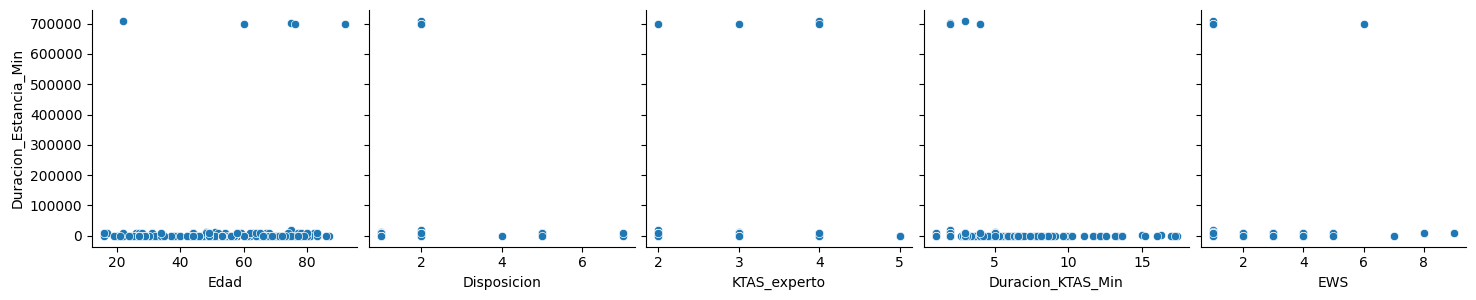

In [597]:
datos["Duracion_KTAS_Min"] = datos["Duracion_KTAS_Min"].str.replace(',', '.').astype('float64')
sns.pairplot(datos.sample(frac=0.2), height=3, y_vars="Duracion_Estancia_Min", x_vars=candidatas, kind="scatter")

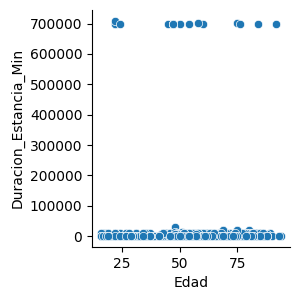

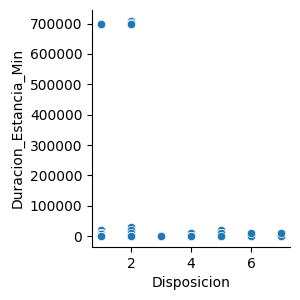

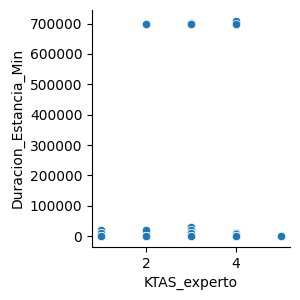

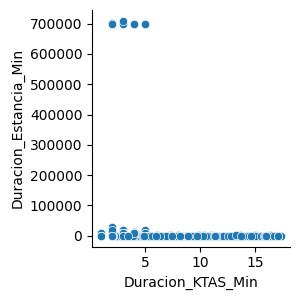

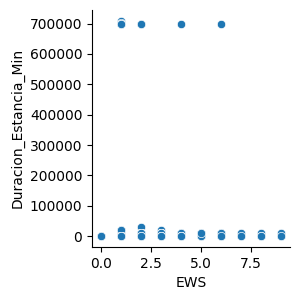

In [598]:
for variable in candidatas:
    sns.pairplot(datos, height=3, y_vars="Duracion_Estancia_Min", x_vars=variable, kind="scatter")

In [599]:
datos["Modo_Llegada"] = datos["Modo_Llegada"].apply(lambda x: 1 if x == 1 else (2 if x == 2 or x ==4 else (3 if x == 3 else 4)))


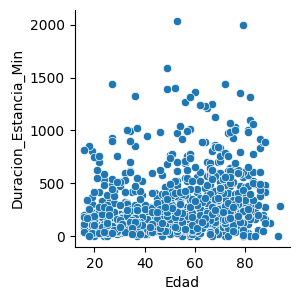

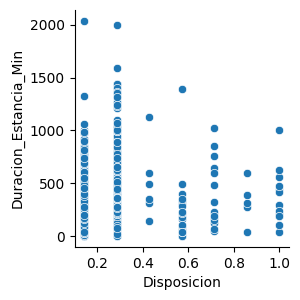

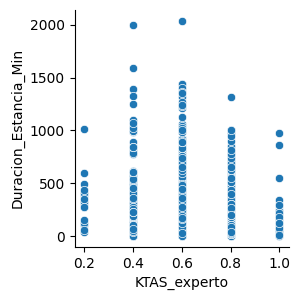

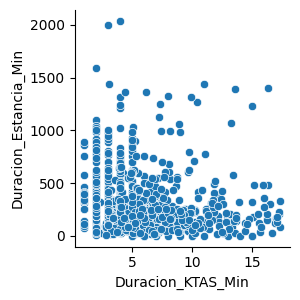

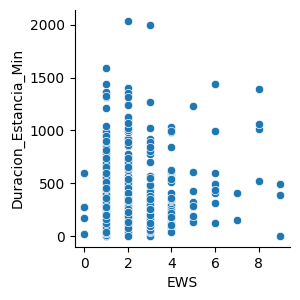

In [621]:
prueba=datos[datos["Duracion_Estancia_Min"]<=4000]
for variable in candidatas:
    sns.pairplot(prueba, height=3, y_vars="Duracion_Estancia_Min", x_vars=variable, kind="scatter")

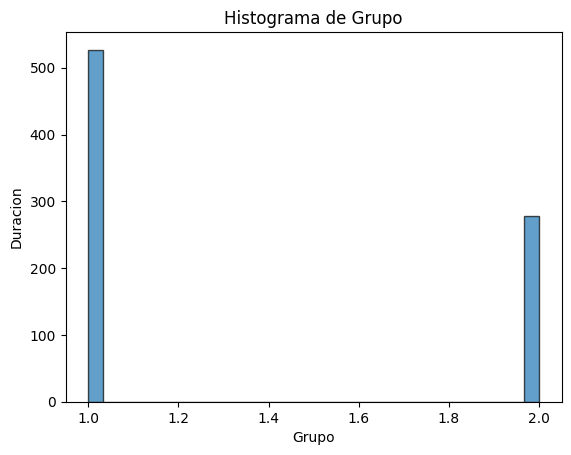

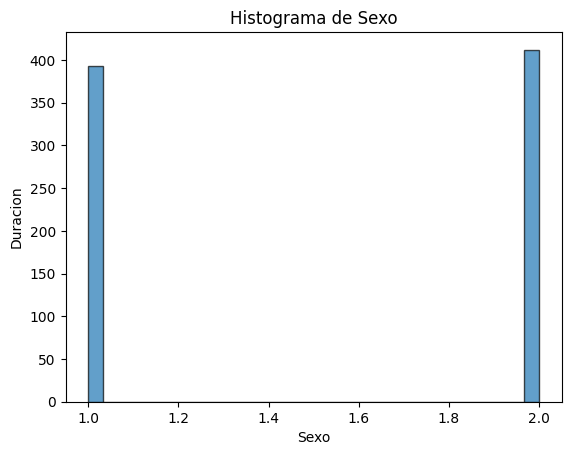

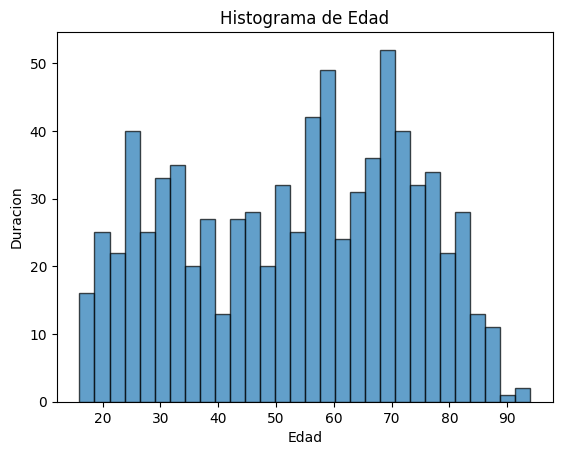

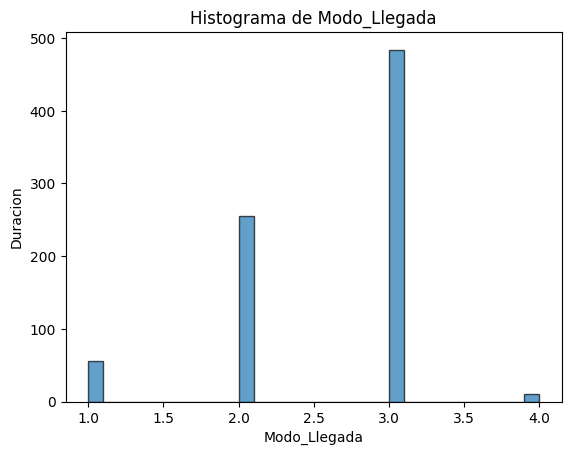

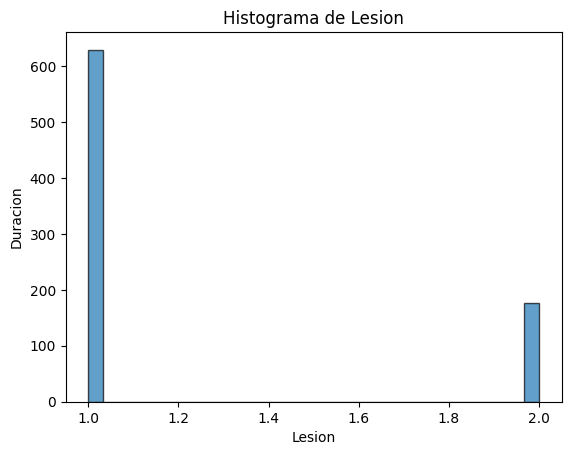

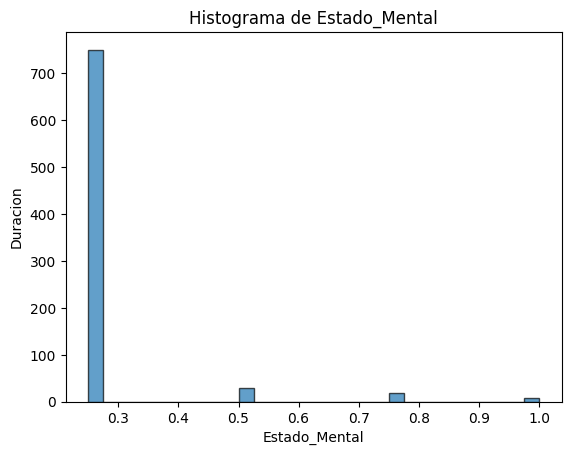

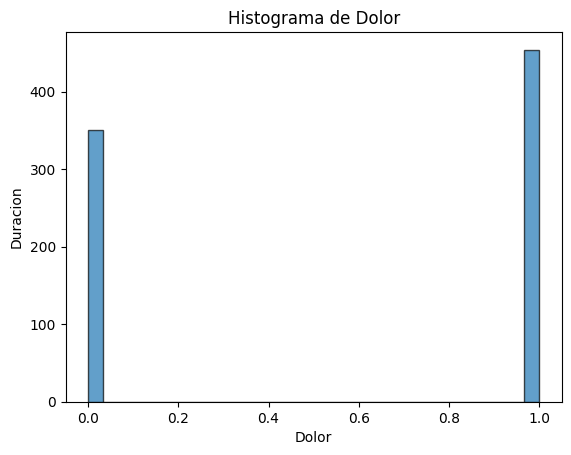

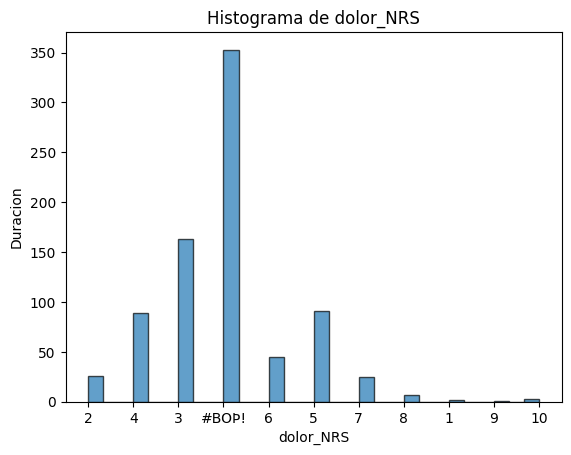

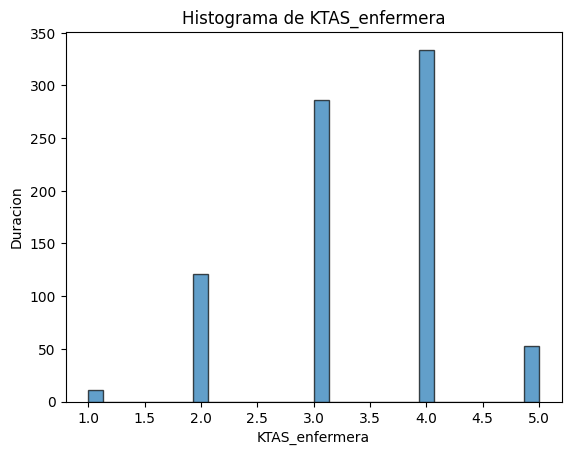

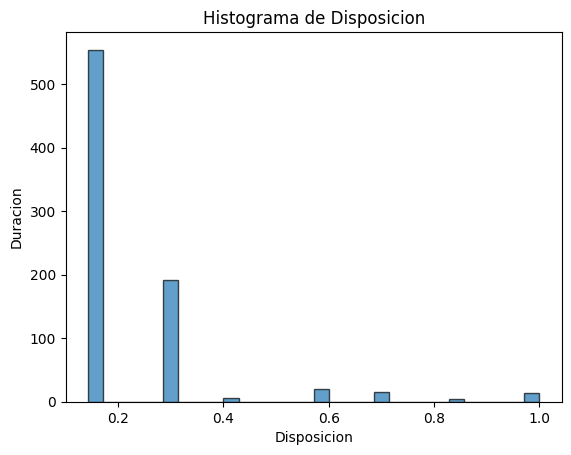

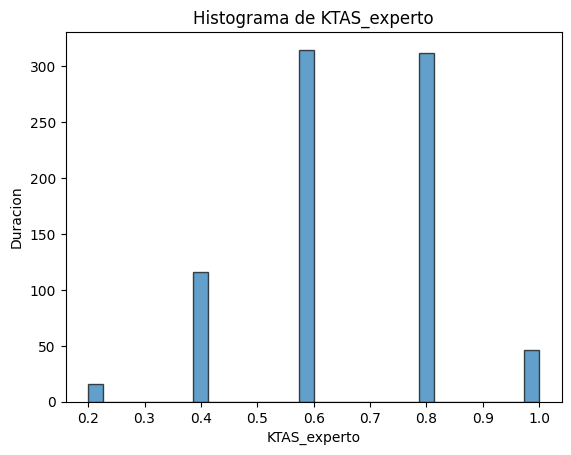

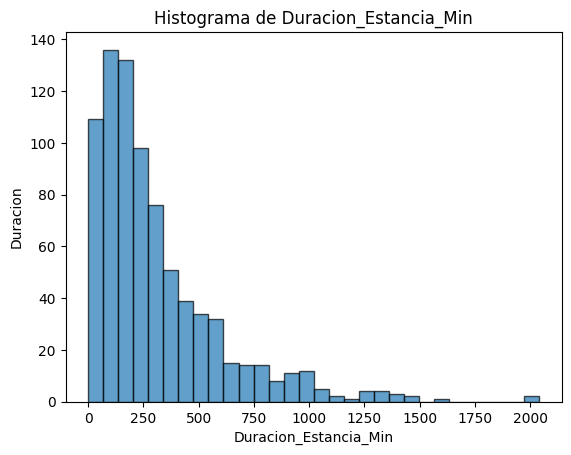

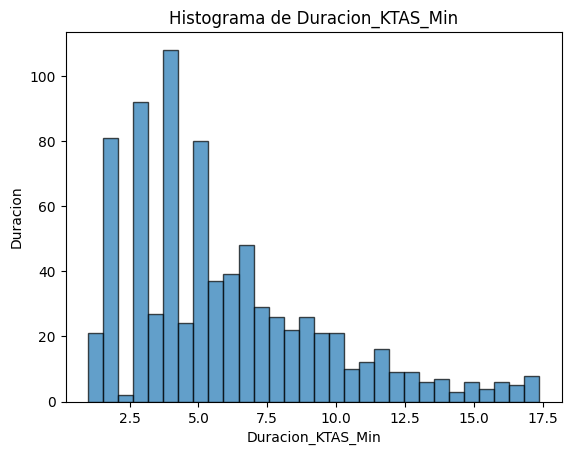

In [641]:
for variable in numericas:
    plt.hist(prueba[variable], bins=30, edgecolor='k', alpha=0.7)
    plt.title('Histograma de ' + variable)
    plt.xlabel(variable)
    plt.ylabel('Duracion')
    plt.show()

C:\Users\cesar\AppData\Roaming\Python\Python310\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


Parámetros ajustados: n=5.0, p=0.5


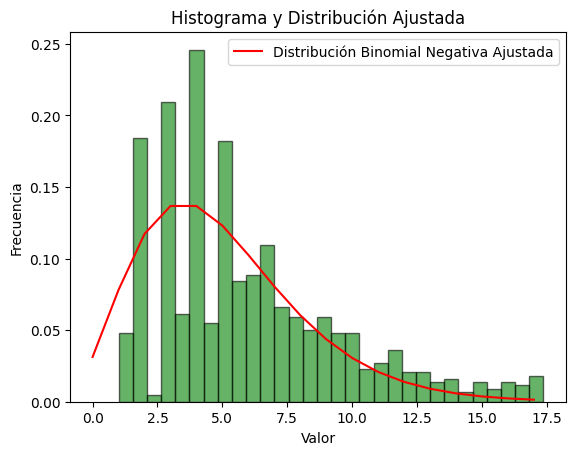

In [651]:
# Definir la función de log-verosimilitud
def negative_binomial_log_likelihood(params, data):
    n, p = params
    return -np.sum(stats.nbinom.logpmf(data, n, p))

# Estimar parámetros usando scipy.optimize
initial_guess = [5, 0.5]  # Valores iniciales para n y p
result = optimize.minimize(negative_binomial_log_likelihood, initial_guess, args=(prueba["Duracion_KTAS_Min"],), bounds=[(1, None), (0.01, 0.99)])

n_est, p_est = result.x
print(f"Parámetros ajustados: n={n_est}, p={p_est}")

# Graficar los datos y la distribución ajustada
x = np.arange(0, prueba["Duracion_KTAS_Min"].max())
pdf_fitted = stats.nbinom.pmf(x, n_est, p_est)


plt.hist(prueba["Duracion_KTAS_Min"], bins=30, density=True, alpha=0.6, color='g', edgecolor='black')
plt.plot(x, pdf_fitted, 'r-', label='Distribución Binomial Negativa Ajustada')
plt.title('Histograma y Distribución Ajustada')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

Parámetros ajustados: shape=0.6122304486381878, loc=0, scale=5.051467957425865


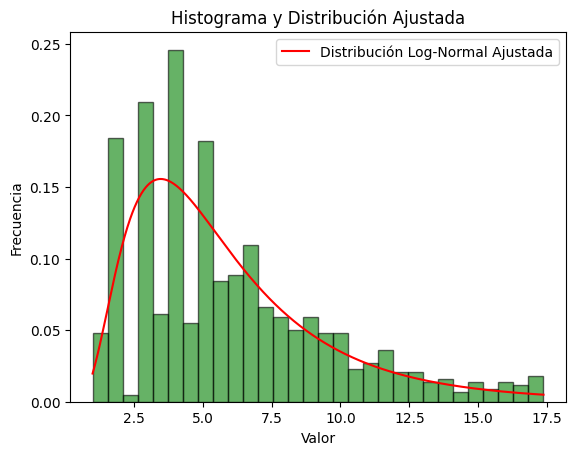

In [648]:
shape, loc, scale = stats.lognorm.fit(prueba["Duracion_KTAS_Min"], floc=0)

print(f"Parámetros ajustados: shape={shape}, loc={loc}, scale={scale}")

# Graficar el histograma de los datos y la distribución ajustada
x = np.linspace(min(prueba["Duracion_KTAS_Min"]), max(prueba["Duracion_KTAS_Min"]), 805)
pdf_fitted = stats.lognorm.pdf(x, shape, loc, scale)

plt.hist(prueba["Duracion_KTAS_Min"], bins=30, density=True, alpha=0.6, color='g', edgecolor='black')
plt.plot(x, pdf_fitted, 'r-', label='Distribución Log-Normal Ajustada')
plt.title('Histograma y Distribución Ajustada')
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

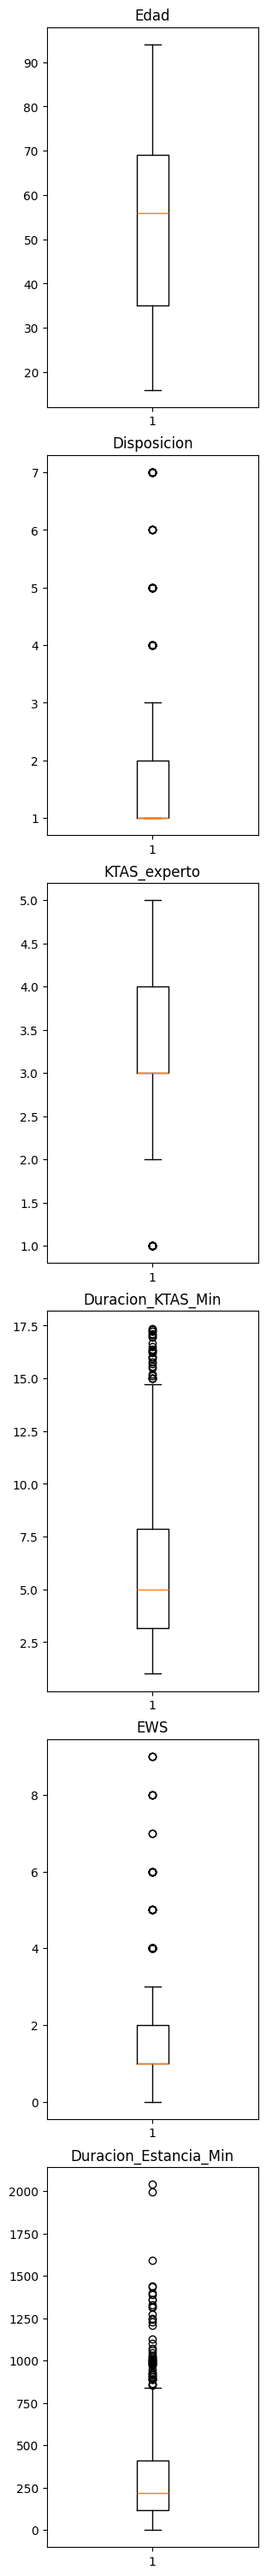

In [601]:
candidatas2=candidatas+["Duracion_Estancia_Min"]
fig, ax = plt.subplots(len(candidatas2), 1, layout="constrained", figsize=(3,30))
for i in range(len(candidatas2)):
    ax[i].boxplot(prueba[candidatas2[i]])
    ax[i].set_title(candidatas2[i])

<Axes: xlabel='Duracion_Estancia_Min'>

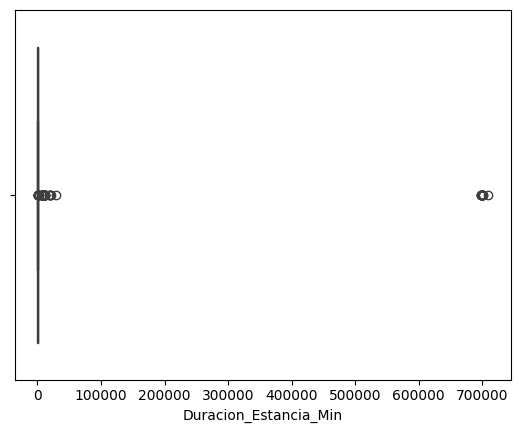

In [602]:
sns.boxplot(datos, x="Duracion_Estancia_Min")

(849, 24)

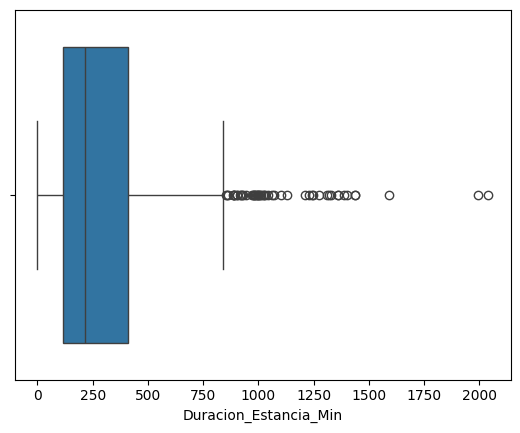

In [603]:

sns.boxplot(prueba, x="Duracion_Estancia_Min")
prueba.shape

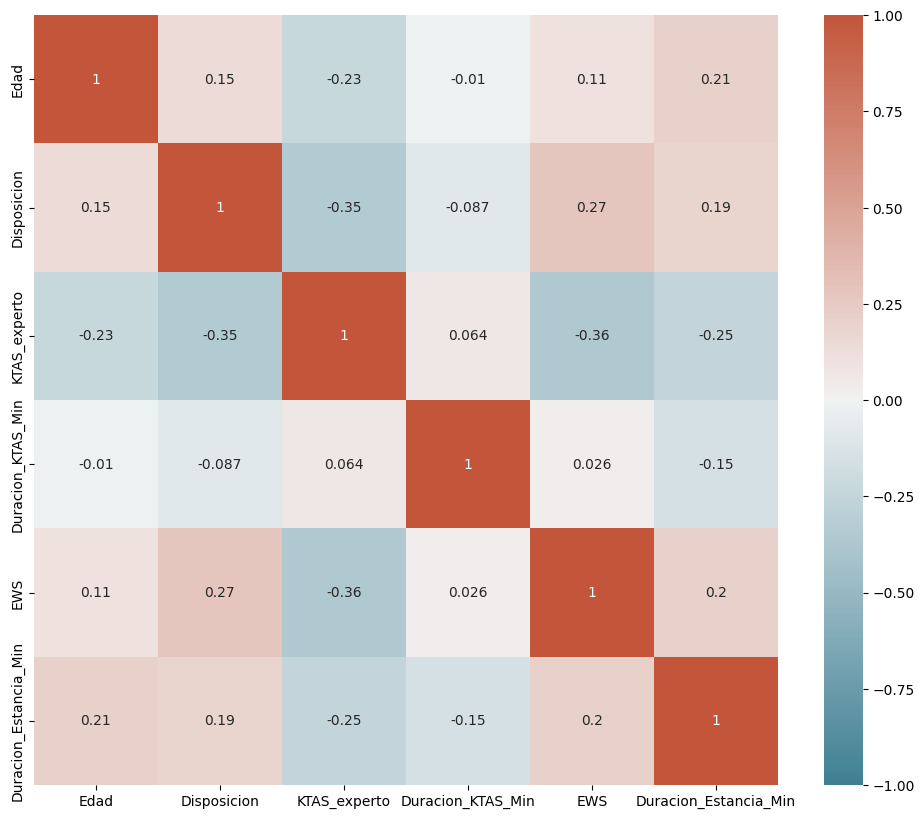

In [604]:
plt.figure(figsize=(12, 10))
# Crear una paleta de colores divergente con el color blanco en el centro
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Crear el heatmap con la paleta personalizada
sns.heatmap(
    prueba[candidatas + ['Duracion_Estancia_Min']].corr(),
    cmap=cmap,
    vmin=-1, vmax=1,
    annot=True
)

plt.show()

### 2.2. Búsqueda de relaciones entre las variables de entrada

**Importante:** La regresión lineal asume que sus variables de entrada no se encuentran altamente correlacionados.

<Axes: >

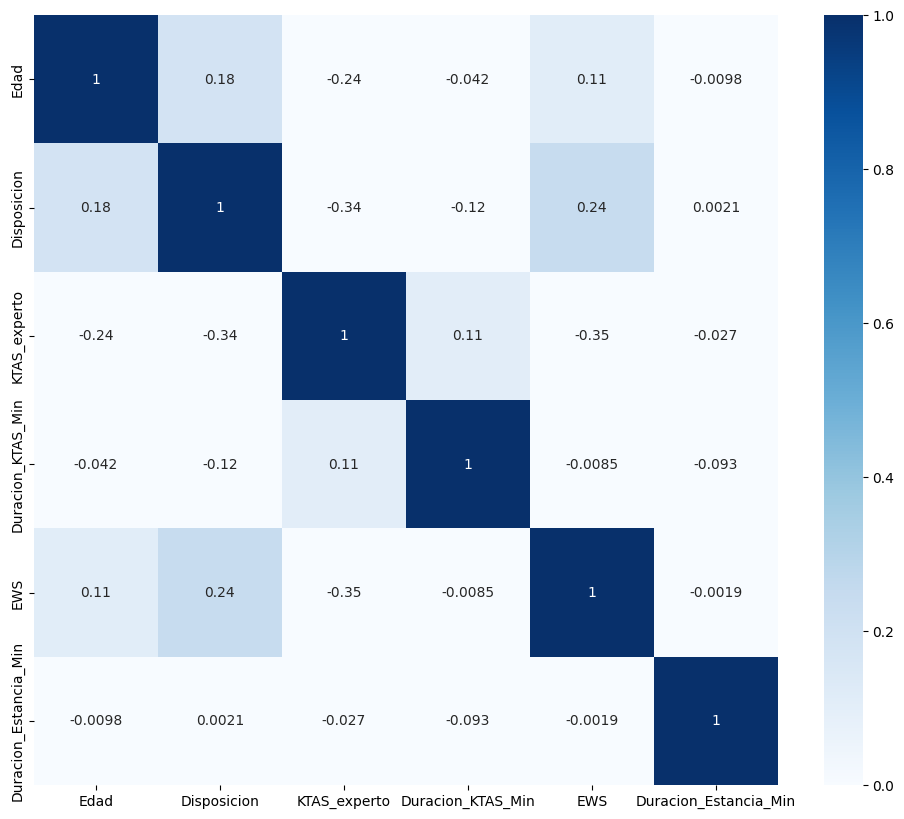

In [605]:
plt.figure(figsize=(12, 10))
sns.heatmap(datos[candidatas+['Duracion_Estancia_Min']].corr(), cmap="Blues", vmin=0, vmax=1, annot = True)

## 3. Preparación de datos

### 3.1. Relacionado con la calidad de los datos

In [606]:
datos=datos[datos["Duracion_Estancia_Min"]<=4000]
datos["Disposicion"]=datos["Disposicion"]/7
datos["KTAS_experto"]=datos["KTAS_experto"]/5
datos["Estado_Mental"]=datos["Estado_Mental"]/4

In [607]:
# Se eliminan los registros totalmente duplicados
datos = datos.dropna(subset=["Duracion_Estancia_Min"]+candidatas)

In [608]:
datos.shape
total_rows = datos.shape[0]
total_rows

849

In [609]:
datos[["Duracion_Estancia_Min"]+candidatas].isnull().sum() / datos.shape[0]

Duracion_Estancia_Min    0.0
Edad                     0.0
Disposicion              0.0
KTAS_experto             0.0
Duracion_KTAS_Min        0.0
EWS                      0.0
dtype: float64

In [610]:
datos[datos[["Duracion_Estancia_Min"]+candidatas] == '#BOÞ!'][["Duracion_Estancia_Min"]+candidatas].count()/ datos.shape[0]

Duracion_Estancia_Min    0.0
Edad                     0.0
Disposicion              0.0
KTAS_experto             0.0
Duracion_KTAS_Min        0.0
EWS                      0.0
dtype: float64

In [611]:
datos.loc[datos.duplicated(subset=candidatas, keep=False)].head(5)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS
9,2,2,27,2,1,LLQ pain,0.25,1,3,130.0,...,97.0,4,Unspecified abdominal pain,0.142857,0.8,0,493,2.00,0,1
20,1,2,78,3,1,dizziness,0.25,0,#BOÞ!,132.0,...,NaN,3,Dizziness,0.142857,0.6,0,129,5.38,0,2
36,2,1,33,3,1,Vaginal Bleeding,0.25,1,6,160.0,...,100.0,4,"Abnormal uterine and vaginal bleeding, unspeci...",0.142857,0.8,0,191,3.00,0,1
55,2,2,40,3,1,"Leg pain, NOS",0.25,1,3,110.0,...,NaN,5,Complex regional pain syndrome type II,0.142857,1.0,0,60,2.00,0,1
70,2,1,77,3,1,fever,0.25,1,3,120.0,...,96.0,4,"Infective arthritis NOS, pelvic region and thigh",0.285714,0.8,0,205,3.00,0,1


In [612]:
duplicated_rows = datos.loc[datos.duplicated(subset=candidatas, keep=False)].shape[0]
duplicated_rows

85

In [613]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 10.0118%


In [614]:
datos.loc[datos.duplicated(subset=candidatas+["Duracion_Estancia_Min"], keep=False)].tail(4)

,Grupo,Sexo,Edad,Modo_Llegada,Lesion,Queja_Principal,Estado_Mental,Dolor,dolor_NRS,SBP,...,Saturacion,KTAS_enfermera,Diagnostico_En_Urgencias,Disposicion,KTAS_experto,Grupo_De_Error,Duracion_Estancia_Min,Duracion_KTAS_Min,Error_Triaje,EWS
996,1,1,27,3,1,Suicidal Attempt,0.25,0,#BOÞ!,110.0,...,NaN,3,Suicide tendency,0.285714,0.6,0,442,7.42,0,1
997,1,2,54,2,1,"pain, chest",0.25,1,6,159.0,...,NaN,2,Gastroesophageal reflux disease,0.142857,0.4,0,214,4.95,0,1
998,1,1,19,3,1,eye discomfort,0.25,0,#BOÞ!,132.0,...,NaN,4,Corneal erosion,0.142857,0.8,0,50,3.45,0,1
999,1,2,29,3,1,"pain, abdominal",0.25,1,6,137.0,...,NaN,3,Allergic reaction,0.142857,0.6,0,116,5.97,0,1


In [615]:
duplicated_rows = datos.loc[datos.duplicated(subset=candidatas+["Duracion_Estancia_Min"], keep=False)].shape[0]
duplicated_rows

59

In [616]:
print(f"Duplicates: {(duplicated_rows/total_rows)*100:.4f}%")

Duplicates: 6.9494%


In [617]:
datos.drop_duplicates(subset=candidatas, inplace=True)
datos.drop_duplicates(subset=candidatas+["Duracion_Estancia_Min"], inplace=True)

In [618]:
datos.shape

(805, 24)

Train: 257.0383076561674
Test: 295.27650236713237


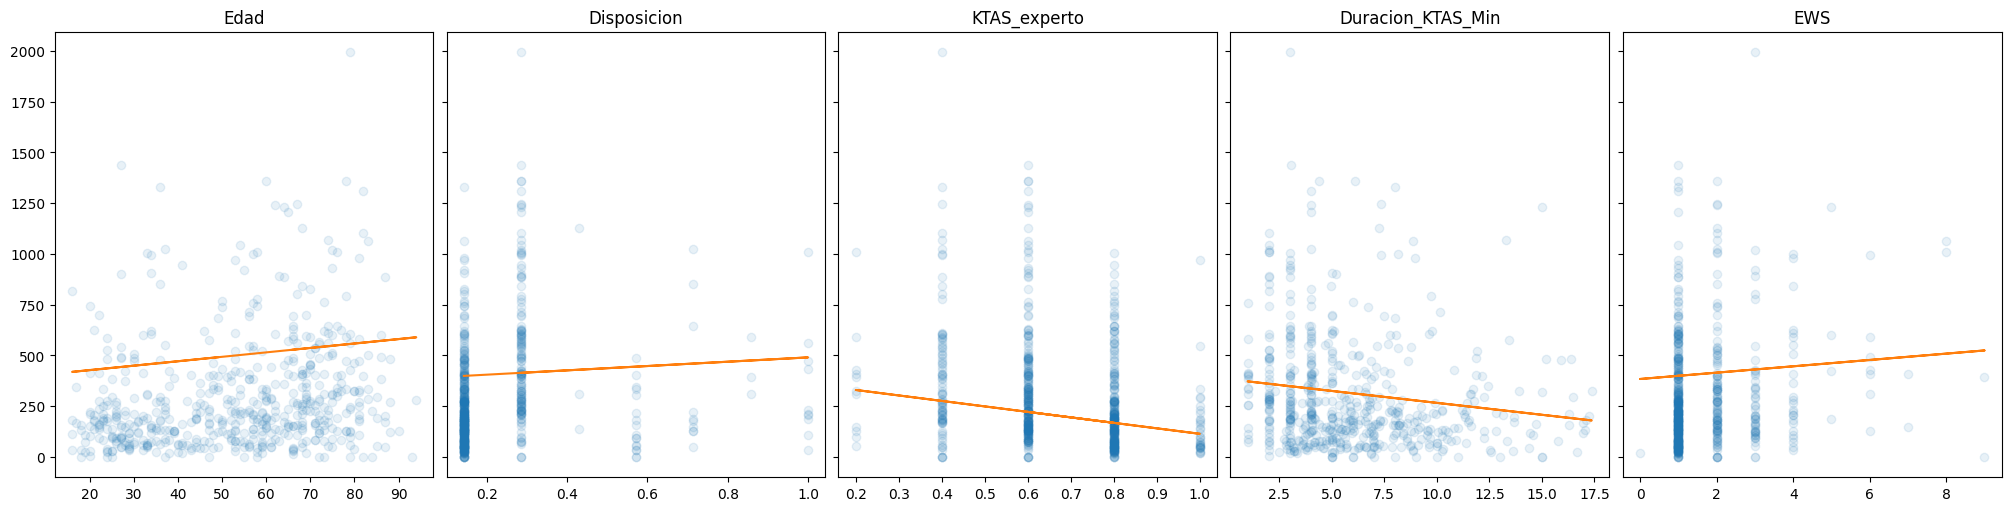

In [619]:
X_train, X_test, y_train, y_test = train_test_split(datos[candidatas], datos["Duracion_Estancia_Min"], test_size=0.3, random_state=1)
X_train.shape, y_train.shape
X_test.shape, y_test.shape
regression = LinearRegression()
regression.fit(X_train, y_train)
pd.DataFrame({"columns": candidatas, "coef": regression.coef_})
f, axs = plt.subplots(1, len(candidatas), sharey=True, figsize=(20, 5), layout="constrained")

for i in range(len(candidatas)):
    col = candidatas[i]
    x = X_train[col]
    m = regression.coef_[i]
    b = regression.intercept_

    axs[i].plot(x, y_train, "o", alpha=0.1)
    axs[i].plot(x, x * m + b)
    axs[i].set_title(col)
print("Train:", np.sqrt(mean_squared_error(y_train, regression.predict(X_train))))
print("Test:", np.sqrt(mean_squared_error(y_test, regression.predict(X_test))))
